In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/fintech

Mounted at /content/drive
/content/drive/My Drive/fintech


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 12.4 MB/s 
     |████████████████████████████████| 182 kB 80.4 MB/s 
     |████████████████████████████████| 7.6 MB 60.2 MB/s 


In [3]:
path = "/content/drive/My Drive/fintech"

In [4]:
import transformers as ppb
''' For DistilBERT: samller, faster, cheaper, lighter 40% less parameters than bert-base-uncased
    run 60% faster
    95% of BERT's performance as meassured on the GLUE language understanding benchmark. 
'''
# Create tuple for DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, "distilbert-base-uncased")
# Load pretrained model andtokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
# bert = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
import pandas as pd
import numpy as np  
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score
import time

import warnings 
warnings.filterwarnings('ignore')
import gc
import copy
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Load the TensorBoard notebook extension
%load_ext tensorboard
############## TENSORBOARD ########################
import sys
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'{path}/tensorboard/runs')
###################################################

def getDevice(device):
  if device != 'cpu':
    is_cuda =  torch.cuda.is_available()
    if is_cuda:
      return torch.device('cuda')
    return torch.device('cpu')
  return torch.device('cpu')


# Create the BertClassfier class
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        bertView_out = 768
        bertTitle_out = 768
        bertTitleReview_out = 768
        input_size = 36

        h0 = 1024
        h1 = 512
        h2 = 128
        h3 = 64
        # h4 = 32
        out = 1

        titleReviewIn = bertTitle_out + bertTitleReview_out + input_size
        titleReviewOut = bertTitle_out + bertTitleReview_out + input_size + 2
        concatenate = h3 + bertView_out
        concatenate1 = concatenate + 2

        

        self.bert_reviews = model_class.from_pretrained(pretrained_weights)
        self.title = model_class.from_pretrained(pretrained_weights)
        self.title_review = model_class.from_pretrained(pretrained_weights)

        self.l1 = nn.Linear(titleReviewIn, titleReviewOut)
        self.act1 = nn.ReLU()
        self.d1 = nn.Dropout(p=0.5)

        self.l2 = nn.Linear(titleReviewOut, h0)
        self.act2 = nn.ReLU()
        self.d2 = nn.Dropout(p=0.5)

        self.l3 = nn.Linear(h0, h1)
        self.act3 = nn.ReLU()
        self.d3 = nn.Dropout(p=0.2)

        self.l4 = nn.Linear(h1, h1)
        self.act4 = nn.ReLU()
        self.d4 = nn.Dropout(p=0.2)

        self.l5 = nn.Linear(h1, h2)
        self.act5 = nn.ReLU()
        self.d5 = nn.Dropout(p=0.2)

        self.l6 = nn.Linear(h2, h3)
        self.act6 = nn.ReLU()
        self.d6 = nn.Dropout(p=0.2)


        self.l7 = nn.Linear(concatenate,  concatenate1)
        self.act7 = nn.ReLU()
        self.d7 = nn.Dropout(p=0.5)


        self.l8 = nn.Linear(concatenate1 , h1 )
        self.act8 = nn.ReLU()
        self.d8 = nn.Dropout(p=0.5)

        self.l9 = nn.Linear(h1 , h2 )
        self.act9 = nn.ReLU()
        self.d9 = nn.Dropout(p=0.2)

        self.l10 = nn.Linear(h2 , h2 )
        self.act10 = nn.ReLU()
        self.d10 = nn.Dropout(p=0.2)

        self.l11 = nn.Linear(h2 , h3 )
        self.act11 = nn.ReLU()
        self.d11 = nn.Dropout(p=0.2)

        self.l12 = nn.Linear(h3 , 1 )
    

        self.out = nn.Sigmoid()


        # Freeze the BERT model
        if freeze_bert:
        
            for param in self.bert_reviews.parameters():
                param.requires_grad = False

            for param in self.title.parameters():
                param.requires_grad = False

            for param in self.title_review.parameters():
                param.requires_grad = False
        
    def forward(self, reviews, title, title_review, inputs):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    reviews (obj) : ** keword argument [batch_size, hidden layer bert model : 512, output bert model 768]
        @param    inputs (torch.Tensor): Category(30) + Ranking(5) + Verified Purchased(1) 
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        bert_reviews = self.bert_reviews(**reviews)
        title = self.title(**title)
        title_review = self.title_review(**title_review)

        bert_reviews_state_cls = bert_reviews['last_hidden_state'][:, 0, :]
        bert_title_state_cls = title['last_hidden_state'][:, 0, :]
        bert_title_review_state_cls = title_review['last_hidden_state'][:, 0, :]

        concatenate1 = torch.cat((bert_title_state_cls, bert_title_review_state_cls, inputs), 1)
        out = self.l1(concatenate1)
        out = self.act1(out)
        out = self.d1(out)

        out = self.l2(out)
        out = self.act2(out)
        out = self.d2(out)

        out = self.l3(out)
        out = self.act3(out)
        out = self.d3(out)

        out = self.l4(out)
        out = self.act4(out)
        out = self.d4(out)

        out = self.l5(out)
        out = self.act5(out)
        out = self.d5(out)

        out = self.l6(out)
        out = self.act6(out)
        out = self.d6(out)

        concatenate2 = torch.cat((out, bert_reviews_state_cls), 1)
        out = self.l7(concatenate2)
        out = self.act7(out)
        out = self.d7(out)

        out = self.l8(out)
        out = self.act8(out)
        out = self.d8(out)

        out = self.l9(out)
        out = self.act9(out)
        out = self.d9(out)

        out = self.l10(out)
        out = self.act10(out)
        out = self.d10(out)

        out = self.l11(out)
        out = self.act11(out)
        out = self.d11(out)

        out = self.l12(out)

        return self.out(out)



class prepareData():
    def __init__(self):
      reviews = pd.read_csv('./amazon_reviews.txt', delimiter='\t')
      self.reviews_original = reviews.copy()
        
      reviews.loc[reviews['LABEL'] == '__label1__', "LABEL"] = 0
      reviews.loc[reviews["LABEL"] == '__label2__', "LABEL"] = 1

      reviews.loc[reviews['VERIFIED_PURCHASE'] == 'N', "VERIFIED_PURCHASE"] = 0
      reviews.loc[reviews["VERIFIED_PURCHASE"] == 'Y', "VERIFIED_PURCHASE"] = 1

      self.category_label_encoder = LabelEncoder()
      self.category_number_encoder = OneHotEncoder(sparse=False)

      category_label_encoded = self.category_label_encoder.fit_transform(reviews['PRODUCT_CATEGORY'].values)
      category_label_encoded = category_label_encoded.reshape(category_label_encoded.shape[0], 1)
      category_onehot_encoded = self.category_number_encoder.fit_transform(category_label_encoded)

      self.rating_onehot_encoded = OneHotEncoder(sparse=False)
      rating_onehot_encoded = self.rating_onehot_encoded.fit_transform(reviews['RATING'].values.reshape(len(reviews['RATING']), 1))
        
      reviews = self.addToPandas(category_onehot_encoded, reviews, 'category')
      reviews = self.addToPandas(rating_onehot_encoded, reviews, 'rating')

      reviews.drop(['DOC_ID', 'PRODUCT_ID', 'RATING', 'PRODUCT_CATEGORY'], axis=1, inplace=True)
      # self.reviews = reviews

      X = reviews.loc[:, ~reviews.columns.isin(["LABEL"])].values
      Y = reviews['LABEL'].values
      X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, shuffle= True, random_state = 1234 )
      X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.1, shuffle= True, random_state = 1234 )
      
      input_ids_Train_productTitle, attention_mask_Train_productTitle, input_ids_Train_reviewTitle, attention_mask_Train_reviewTitle, input_ids_Train_reviewText, attention_mask_Train_reviewText = self.extractReviewsToInputMaskAttention(X_train)
      input_ids_validate_productTitle, attention_mask_validate_productTitle, input_ids_validate_reviewTitle, attention_mask_validate_reviewTitle, input_ids_validate_reviewText, attention_mask_validate_reviewText = self.extractReviewsToInputMaskAttention(X_validate)
      input_ids_test_productTitle, attention_mask_test_productTitle, input_ids_test_reviewTitle, attention_mask_test_reviewTitle, input_ids_test_reviewText, attention_mask_test_reviewText = self.extractReviewsToInputMaskAttention(X_test)
      
      X_train = np.delete(X_train, obj=[1,2,3], axis=1)
      X_validate = np.delete(X_validate, obj=[1,2,3], axis=1)
      X_test = np.delete(X_test, obj=[1,2,3], axis=1)


      self.train = self.DatasetClass(
        X_train,
        input_ids_Train_productTitle, 
        attention_mask_Train_productTitle, 
        input_ids_Train_reviewTitle, 
        attention_mask_Train_reviewTitle, 
        input_ids_Train_reviewText, 
        attention_mask_Train_reviewText, 
        y_train
        )

      self.validate = self.DatasetClass(
        X_validate,
        input_ids_validate_productTitle, 
        attention_mask_validate_productTitle, 
        input_ids_validate_reviewTitle, 
        attention_mask_validate_reviewTitle, 
        input_ids_validate_reviewText, 
        attention_mask_validate_reviewText,
        y_validate
        )

      self.test = self.DatasetClass(
        X_test,
        input_ids_test_productTitle, 
        attention_mask_test_productTitle, 
        input_ids_test_reviewTitle, 
        attention_mask_test_reviewTitle, 
        input_ids_test_reviewText, 
        attention_mask_test_reviewText,
        y_test
        )

      del X, Y#, X_train, X_validate, X_test, X_train, X_validate, y_train, y_validate,
      del input_ids_Train_productTitle, 
      attention_mask_Train_productTitle, 
      input_ids_Train_reviewTitle, 
      attention_mask_Train_reviewTitle, 
      input_ids_Train_reviewText, 
      attention_mask_Train_reviewText,
      input_ids_validate_productTitle, 
      attention_mask_validate_productTitle, 
      input_ids_validate_reviewTitle, 
      attention_mask_validate_reviewTitle, 
      input_ids_validate_reviewText, 
      attention_mask_validate_reviewText,
      input_ids_test_productTitle, 
      attention_mask_test_productTitle, 
      input_ids_test_reviewTitle, 
      attention_mask_test_reviewTitle, 
      input_ids_test_reviewText, 
      attention_mask_test_reviewText

      gc.collect()

       

    def extractReviewsToInputMaskAttention(self, data):
      X_Bert_productTitle = data[:,1]
      X_Bert_reviewTitle = data[:,2]
      X_Bert_reviewText = data[:,3]

      input_ids_X_Bert_productTitle, attention_mask_X_Bert_productTitle = self.prepareDataForBert(X_Bert_productTitle)
      input_ids_X_Bert_reviewTitle, attention_mask_X_Bert_reviewTitle = self.prepareDataForBert(X_Bert_reviewTitle)
      input_ids_X_Bert_reviewText, attention_mask_X_Bert_reviewText = self.prepareDataForBert(X_Bert_reviewText)
      
      return input_ids_X_Bert_productTitle, attention_mask_X_Bert_productTitle, \
      input_ids_X_Bert_reviewTitle, attention_mask_X_Bert_reviewTitle, \
      input_ids_X_Bert_reviewText, attention_mask_X_Bert_reviewText


    def addToPandas(self, data, dataPandas, prefix=''):
      pbar = tqdm_notebook(total = data.shape[1])
      pbar.set_description(f'Data prefix {prefix}')
      
      for i in range(data.shape[1]):
        dataPandas[f'{prefix}_{i}'] = data[:, i]
        pbar.update(1)
      pbar.close()

      return dataPandas

    def prepareDataForBert(self, data):
      tokenized = []

      pbar = tqdm_notebook(total = len(data))
      pbar.set_description(f'Tokenized: ')
      for i in data:
        tokenized.append(tokenizer.encode(i, add_special_tokens = True, truncation=True))
        pbar.update(1)
      pbar.close()
    
      max_len = 0
      for i in tokenized:
        if len(i) > max_len:
          max_len = len(i)

      padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
      attention_mask = np.where(padded != 0, 1, 0)
      
      return padded, attention_mask

    class DatasetClass(Dataset):
      ''' 
        inputs => VERIFIED_PURCHASE, CATEGORY, RATING
        PRODUCT_TITLE
        REVIEW_TITLE
        REVIEW_TEXT
      '''
      def __init__(
        self, 
        inputs, 
        input_ids_productTitle, 
        attention_mask_productTitle, 
        input_ids_reviewTitle, 
        attention_mask_reviewTitle, 
        input_ids_reviewText, 
        attention_mask_reviewText, 
        labels
        ):


        self.inputs = torch.from_numpy(np.asarray(inputs, dtype=np.int8))
        self.labels = torch.from_numpy(np.asarray(labels.reshape(labels.shape[0], 1), dtype=np.float32)).to(torch.float32)
        # labels = torch.from_numpy(labels.reshape(labels.shape[0], 1))
        # self.labels = torch.from_numpy(np.asarray(labels, dtype=np.int8))

        self.input_ids_productTitle = torch.tensor(input_ids_productTitle)        
        self.attention_mask_productTitle = torch.tensor(attention_mask_productTitle)

        self.input_ids_reviewTitle = torch.tensor(input_ids_reviewTitle)
        self.attention_mask_reviewTitle = torch.tensor(attention_mask_reviewTitle)

        self.input_ids_reviewText = torch.tensor(input_ids_reviewText)
        self.attention_mask_reviewText = torch.tensor(attention_mask_reviewText)

        self.n_samples = inputs.shape[0]

      def __getitem__(self, index):
        return self.inputs[index], \
        self.input_ids_productTitle[index], \
        self.attention_mask_productTitle[index], \
        self.input_ids_reviewTitle[index], \
        self.attention_mask_reviewTitle[index], \
        self.input_ids_reviewText[index], \
        self.attention_mask_reviewText[index], \
        self.labels[index]

      def __len__(self):
        return self.n_samples 


class AI_Model():
  def __init__(self, train, validate, test, device, batch_size = 1, epoch = 1, learning_rate = 1e-3, loadModelFlag = False, loadModelFile = ''):
    self.batch_size = batch_size
    self.epoch =  epoch
    self.device = device
    

    self.train = DataLoader(dataset = train, batch_size = self.batch_size, shuffle = True)
    self.validation = DataLoader(dataset = validate, batch_size = self.batch_size, shuffle = False)
    self.test = DataLoader(dataset = test, batch_size = self.batch_size, shuffle = False)

    self.model = self.loadModel(loadModelFlag = loadModelFlag, loadModelFile = loadModelFile)
    self.lossFunction = nn.BCELoss()  
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
   
  

  def loadModel(self, loadModelFlag = False, loadModelFile = ''):
    if loadModelFlag:
      if loadModelFile != '':
        return torch.load(loadModelFile).to(self.device)
    return BertClassifier(freeze_bert = True).to(self.device)


  '''
       Metrics         
  '''
  def metrics(self, y, y_hat, typeMetric = 'Acc' ):
      
      precision, recall, thresholds = precision_recall_curve(y, y_hat)

      if typeMetric == 'f1':
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        return  fscore[ix]
      elif typeMetric == 'recall':
        ix = np.argmax(recall)
        return recall[ix]
      elif typeMetric == 'precision':
        ix = np.argmax(precision)
        return precision[ix]
      elif typeMetric == 'AUROC':
        return roc_auc_score(y, y_hat)
      elif typeMetric == 'PRC':
        return auc(recall, precision)
      elif typeMetric == 'acc':
        return accuracy_score(y, y_hat.round()) * 100



  def trainModel(self, show_process = True, process_factor = 10, patiente = 2, typeMetric = 'acc',  earlyStopFlag=True):

    pbarEpoch = tqdm_notebook(total = self.epoch)
    pbarEpoch.set_description('Epoch: ')

    self.lossTraining = []
    self.accTraining = []
    self.lossValidation = []
    self.accValidation  = []

    patiente_acum = 0  # patiente counter

    prev_metric = -1e2  # best loss from validation
    best_Model =  copy.deepcopy(self.model.state_dict()) # best model
    self.best_epoch = 0

    for epoch in range(self.epoch):

      y_hat = []
      y = []
      flag = True

      loss_train = 0.0
      acc_train  = 0.0
      
      
      self.model.train()
      for idx, (inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels) in enumerate(self.train):
        productTitle = {
          "input_ids": input_ids_productTitle.to(self.device), 
          "attention_mask": attention_mask_productTitle.to(self.device)
          }
        reviewTitle = {
          "input_ids": input_ids_reviewTitle.to(self.device), 
          "attention_mask": attention_mask_reviewTitle.to(self.device)
          }
        reviewText = {
          "input_ids": input_ids_reviewText.to(self.device), 
          "attention_mask": attention_mask_reviewText.to(self.device)
          }
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        '''
                    ---------------   Forward    --------------------
        '''
        outputs = self.model(reviewText, productTitle, reviewTitle, inputs)
        loss = self.lossFunction(outputs, labels)
      
        

        '''
                    ---------------   Backward    --------------------
        '''
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        self.optimizer.zero_grad()

        '''
                    ---------------  Get predicted to calculate accuracy ----------------
        '''
        predicted = outputs.cpu().detach().numpy()
        ground_truth = labels.cpu().detach().numpy()

        if flag:
          y_hat = predicted
          y = ground_truth
          flag = False

        y_hat = np.append(y_hat, predicted)
        y = np.append(y, ground_truth)

        acc = self.metrics(y, y_hat, typeMetric = 'acc')

        if show_process:
          if (idx + 1) % process_factor== 0:
              text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.train)} | Training loss: {loss.item():.5f} |  Training Accuracy: {acc:.5f}'
              print(text)
        
        
        loss_train = loss.item()
        acc_train = acc
        pbarEpoch.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            'training Acc': acc_train, 
            'Step': idx,
            'from': len(self.train)
            })

      self.lossTraining.append(loss_train)
      self.accTraining.append(acc_train)
      metric = self.metrics(y, y_hat, typeMetric = typeMetric)

      text = f'Training Stage ==> Epoch: {epoch} / {self.epoch - 1} | Training loss: {loss_train:.5f} |  Training Accuracy: {acc:.5f} | Training Metric {typeMetric}: {metric:.5f}'
      print(text)

      ############## TENSORBOARD ########################
      writer.add_scalar('Loss/Train', loss_train, epoch)
      writer.add_scalar('Accuracy/Train', acc_train, epoch)
      ###################################################
      

      del inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels
      torch.cuda.empty_cache()
      gc.collect()

      ''' 
                ----------------------------------  EVALUATION STAGE  ---------------------------------------
                
      '''
      y_hat = []
      y = []
      flag = True

      loss_val = 0.0
      acc_val  = 0.0
      
      
      self.model.eval()
      with torch.no_grad():
        for idx, (inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels) in enumerate(self.validation):
          productTitle = {
            "input_ids": input_ids_productTitle.to(self.device), 
            "attention_mask": attention_mask_productTitle.to(self.device)
            }
          reviewTitle = {
            "input_ids": input_ids_reviewTitle.to(self.device), 
            "attention_mask": attention_mask_reviewTitle.to(self.device)
          }
          reviewText = {
            "input_ids": input_ids_reviewText.to(self.device), 
            "attention_mask": attention_mask_reviewText.to(self.device)
            }
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)
          '''
                    ---------------   Forward    --------------------
          '''
          outputs = self.model(reviewText, productTitle, reviewTitle, inputs)
          loss = self.lossFunction(outputs, labels)

          predicted = outputs.cpu().detach().numpy()
          ground_truth = labels.cpu().detach().numpy()

          if flag:
            y_hat = predicted
            y = ground_truth
            flag = False

          y_hat = np.append(y_hat, predicted)
          y = np.append(y, ground_truth)
          acc = self.metrics(y, y_hat, typeMetric = 'acc')

          if show_process:
            if (idx + 1) % process_factor== 0:
              text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Step: {idx} / {len(self.validation)} | Validation loss: {loss.item():.5f} |  Validation Accuracy: {acc:.5f}'
              print(text)
        
        
          loss_val = loss.item()
          acc_val = acc
          pbarEpoch.set_postfix({'Epoch':epoch,
            'validation_loss': loss_val, 
            'Validation Acc': acc_val, 
            'Step': idx,
            'from': len(self.validation)
            })
        
        self.lossValidation.append(loss_val)
        self.accValidation.append(acc_val)
        metric = self.metrics(y, y_hat, typeMetric = typeMetric)
        text = f'Validation Stage ==> Epoch: {epoch} / {self.epoch - 1} | Validation loss: {loss_val:.5f} |  Validation Accuracy: {acc:.5f} | Validation Metric {typeMetric}: {metric:.5f}'
        print(text)

        ############## TENSORBOARD ########################
        writer.add_scalar('Loss/Validation', loss_val, epoch)
        writer.add_scalar('Accuracy/Validation', acc_val, epoch)
        ###################################################

        if ~math.isnan(metric) or metric == 0:
          if metric > prev_metric:
            prev_metric = metric
            best_Model =  copy.deepcopy(self.model.state_dict())
            
            
            torch.save(self.model, f'{path}/model/model_EPOCH_{epoch}.pt')

            self.best_epoch = epoch
            patiente_acum = 0
          else:
            patiente_acum += 1
        else:
            patiente_acum += 1


        if earlyStopFlag and patiente_acum > patiente:
          # Load best model in current model
          self.model.load_state_dict(best_Model)
          
          print(f'Early Stop Load Model from best epoch {self.best_epoch}')
          break
      

      
      pbarEpoch.set_postfix({'Epoch':epoch,
            'training_loss': loss_train, 
            f'training Acc': acc_train, 
            'validate_loss': loss_val, 
            f'Validation Acc': acc_val, 
            'patiente': patiente_acum,
            f'Metric {typeMetric}': metric
            })



      del inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels, productTitle, reviewTitle, reviewText
      torch.cuda.empty_cache()
      gc.collect()

    if ~earlyStopFlag:
      # Load best model in current model
      self.model.load_state_dict(best_Model)
      print(f'Load Model from best epoch {self.best_epoch}') 

      pbarEpoch.update(1)
    pbarEpoch.close()


  def testingModel(self, dataset):
    
    torch.cuda.empty_cache()
    gc.collect()

    y_hat = []
    y = []
    flag = True

    lossTest = 0.0
    accTest  = 0.0

    self.model.eval()
    with torch.no_grad():
        for idx, (inputs, input_ids_productTitle, attention_mask_productTitle, input_ids_reviewTitle, attention_mask_reviewTitle, input_ids_reviewText, attention_mask_reviewText, labels) in enumerate(dataset):
          productTitle = {
            "input_ids": input_ids_productTitle.to(self.device), 
            "attention_mask": attention_mask_productTitle.to(self.device)
            }
          reviewTitle = {
            "input_ids": input_ids_reviewTitle.to(self.device), 
            "attention_mask": attention_mask_reviewTitle.to(self.device)
          }
          reviewText = {
            "input_ids": input_ids_reviewText.to(self.device), 
            "attention_mask": attention_mask_reviewText.to(self.device)
            }
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)
          '''
                    ---------------   Forward    --------------------
          '''
          outputs = self.model(reviewText, productTitle, reviewTitle, inputs)
          loss = self.lossFunction(outputs, labels)

          predicted = outputs.cpu().detach().numpy()
          ground_truth = labels.cpu().detach().numpy()

          if flag:
            y_hat = predicted
            y = ground_truth
            flag = False

          y_hat = np.append(y_hat, predicted)
          y = np.append(y, ground_truth)
          lossTest = loss.item()
          accTest = self.metrics(y, y_hat, typeMetric = 'acc')

        text = f'Loss: {lossTest:.5f} |  Validation Accuracy: {accTest:.5f}'
        print(text)
        return y, y_hat

def plot_Accuracy_Loss_Training_Curves(accTraining, accValidation, lossTraining, lossValidation):
    fig, ax = plt.subplots()
    ax.plot(accValidation, label =f'Validation', color='b')
    ax.plot(accTraining, label =f'Training', color='orange')
    # ax.axvline(x = self.best_epoch, color = 'r',  label = 'Epoch')
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    ax.legend(loc="lower right")
    ax.set_ylim((10, 105))
        
    fig1, ax1 = plt.subplots()
    ax1.plot(lossValidation, label =f'Validation', color='b')
    ax1.plot( lossTraining, label =f'Training', color='orange')
    # ax1.axvline(x = self.best_epoch, color = 'r', label = 'Epoch')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(loc="lower right")
    ax1.set_ylim((0, 1))
    plt.show()

def plot_Confusion_Matrix(y, y_hat):
    labels = [0, 1]
    confusion_Matrix = confusion_matrix(y, y_hat)
    sns.heatmap(confusion_Matrix, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
    xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title(f"Confusion Matrix")
    plt.show()


def to_labels(pos_probs, threshold):
  return (pos_probs >= threshold).astype('int')
     
def testModel_GetThreshold(y, y_hat, typeData = 'f1'):
  torch.cuda.empty_cache()
  thresholds = np.arange(0, 1, 0.001)

  if typeData == 'f1':
    scores = [f1_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'AUROC':
    scores = [roc_auc_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'recall':
    scores = [recall_score(y, to_labels(y_hat, t)) for t in thresholds]
    ix = np.argmax(scores)
    return thresholds[ix], scores[ix]
  elif typeData == 'PRC':
    scores = []
    for t in thresholds:
      precision, recall, _ = precision_recall_curve(y, to_labels(y_hat, t))
      scores.append(auc(recall, precision))
    scores = np.array(scores)
    ix = np.argmax(scores)
         
    return thresholds[ix], scores[ix]

def getGmean(y, y_hat):
  fpr, tpr, _ = roc_curve(y, y_hat)
  G_mean = np.sqrt(tpr * (1 - fpr))
  G_mean_index = np.argmax(G_mean)
  print(f"G-mean = {G_mean[G_mean_index]}")
  return G_mean[G_mean_index]

def adjustDataByThreshold(y_hat, threshold):
  t = np.copy(y_hat)
  t[t >= threshold] = 1
  t[t < threshold] = 0
  return t

def ROC_Curve(y, y_hat):
  roc_auc_DNN = roc_auc_score(y, y_hat)
  print(f'AUC : {roc_auc_DNN}')
  # false positive rate, true positive rate
  fpr, tpr, _ = roc_curve(y, y_hat)
        
  plt.figure()
  plt.title('Receiver operating characteristic (ROC)')
  plt.plot(fpr, tpr, label=f'AUC (area = {roc_auc_DNN:.3f})', marker = '.')
  plt.fill_between(fpr, tpr, alpha=0.4)
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.01, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

def PRC_curves(y, y_hat):
  torch.cuda.empty_cache() 
        # Train Dataset
  
  presicionTrain, recallTrain, _  = precision_recall_curve(y, y_hat)
  auc_Train = auc(recallTrain, presicionTrain)
  print(f'AUC : {auc_Train}')

  f1_Train = (2 * presicionTrain * recallTrain) / (presicionTrain + recallTrain)
  

  ix_Train = np.argmax(f1_Train)
  f1_Train = f1_Train[ix_Train]


  fig1, ax =plt.subplots()
  ax.plot(recallTrain, presicionTrain, label=f'Test Dataset: {auc_Train:.4f}', marker = '.')
  ax.fill_between(recallTrain, presicionTrain, alpha=0.4)


  ax.set_xlim([-0.01, 1.05])
  ax.set_ylim([-0.01, 1.05])
  ax.set(title = 'Precision - Recall Curve', xlabel ='Recall', ylabel='Precision')
  ax.legend(loc='lower left') 
  plt.show()

  gc.collect()
  
def test_Report(y, y_hat):
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
  acc = (tp + tn) / (tn + fp + fn + tp)
  precision = tp/(tp +fp)
  recall = tp / (tp + fn)
  f1_score = 2*(precision *recall) / (precision +recall)
  print('accuracy: ', acc)
  print('precision: ', precision)
  print('recall: ', recall)
  print('f1_score: ', f1_score)
  classificationReport = classification_report( y, y_hat, target_names=['real', 'fake'])
  print(classificationReport)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
device = getDevice('gpu')
dataset = prepareData()
dataset.reviews_original.head(3)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/15120 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/1680 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...


In [ ]:
train = dataset.train
validate = dataset.validate
test = dataset.test

__LEARNING_RATE__ = 2.3e-6
__EPOCH__ = 1000

torch.cuda.empty_cache()
gc.collect()

modelTest = AI_Model(train, validate, test, device, batch_size = 4, epoch = __EPOCH__, learning_rate = __LEARNING_RATE__, loadModelFlag = True, loadModelFile = f'{path}/model/model_EPOCH_09.pt')
modelTest.trainModel(show_process = True, process_factor = 1000, patiente = 5, typeMetric = 'AUROC',  earlyStopFlag=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

Training Stage ==> Epoch: 0 / 999 | Step: 999 / 3780 | Training loss: 0.72285 |  Training Accuracy: 61.13886
Training Stage ==> Epoch: 0 / 999 | Step: 1999 / 3780 | Training loss: 0.73500 |  Training Accuracy: 62.00650
Training Stage ==> Epoch: 0 / 999 | Step: 2999 / 3780 | Training loss: 0.73277 |  Training Accuracy: 62.43752
Training Stage ==> Epoch: 0 / 999 | Training loss: 0.69835 |  Training Accuracy: 62.54298 | Training Metric AUROC: 0.67210
Validation Stage ==> Epoch: 0 / 999 | Validation loss: 0.69362 |  Validation Accuracy: 64.42993 | Validation Metric AUROC: 0.71811
Training Stage ==> Epoch: 1 / 999 | Step: 999 / 3780 | Training loss: 0.62780 |  Training Accuracy: 64.61039
Training Stage ==> Epoch: 1 / 999 | Step: 1999 / 3780 | Training loss: 0.57759 |  Training Accuracy: 64.76762
Training Stage ==> Epoch: 1 / 999 | Step: 2999 / 3780 | Training loss: 0.66537 |  Training Accuracy: 65.49484
Training Stage ==> Epoch: 1 / 999 | Training loss: 0.76963 |  Training Accuracy: 66.1399

In [9]:
train = dataset.train
validate = dataset.validate
test = dataset.test
modelTest = AI_Model(train, validate, test, device, batch_size = 1,loadModelFlag = True, loadModelFile = './model/fine_model_EPOCH_final.pt')

In [10]:
torch.cuda.empty_cache()
gc.collect()
y, y_hat = modelTest.testingModel(modelTest.test)

Loss: 0.04799 |  Validation Accuracy: 87.57439


AUC : 0.9337153904734276


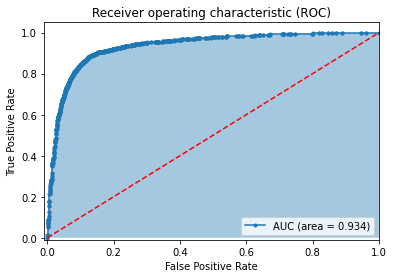

In [14]:
ROC_Curve(y, y_hat)

AUC : 0.9264081960247484


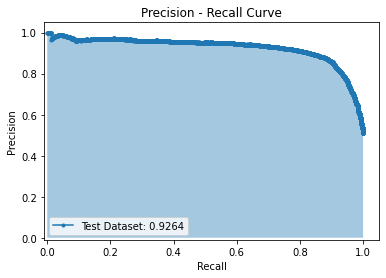

In [15]:
PRC_curves(y, y_hat)

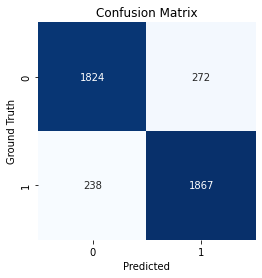

accuracy:  0.8786003332539871
precision:  0.8728377746610566
recall:  0.8869358669833729
f1_score:  0.8798303487276155
              precision    recall  f1-score   support

        real       0.88      0.87      0.88      2096
        fake       0.87      0.89      0.88      2105

    accuracy                           0.88      4201
   macro avg       0.88      0.88      0.88      4201
weighted avg       0.88      0.88      0.88      4201



In [16]:
y_hat_th = adjustDataByThreshold(y_hat, 0.591)
plot_Confusion_Matrix(y, y_hat_th)

test_Report(y, y_hat_th)